# Giới thiệu

Phân loại chữ số viết tay là một trong số những bài toán cơ bản của học máy. Bài toán đặt ra yêu cầu đào tạo máy tính có thể nhận diện và phân biệt được chữ số viết tay của con người.

Trong báo cáo này, em sẽ xây dựng một mạng neural tích chập (CNN) để giải quyết bài toán trên. Cụ thể hơn, các bước xây dựng như sau:
- Phát triển một mô hình cơ sở và thiết lập một cách đánh giá hiệu suất phân loại của mô hình đó.
- Tìm cách phát triển mô hình cơ sở để cải thiện năng lực học tập và khả năng đánh giá.
- Chọn một mô hình tốt nhất, đánh giá hiệu suất và sử dụng để đưa ra dự đoán về hình ảnh mới.

# Chuẩn bị tập dữ liệu

Tập dữ liệu đã sửa đổi của Viện Tiêu chuẩn và Kĩ thuật Quốc gia (MNIST) là một tập dữ liệu chứa các hình ảnh của các chữ số viết tay từ 0 đến 9. Bài toán yêu cầu phân loại một hình ảnh của một chữ số viết tay thành một trong 10 lớp đại diện cho các giá trị nguyên lần lượt từ 0 đến 9.

Tập dữ liệu gồm 60,000 ảnh trong training set và 10,000 ảnh trong test set. Tất cả các hình ảnh đều là ảnh đen trắng, kích thước 28x28 pixel.

## Tải tập dữ liệu

Sử dụng API [load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) của Keras để tải tập dữ liệu về và tạo một biểu đồ chứa 9 hình ảnh đầu tiên trong tập dữ liệu.

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


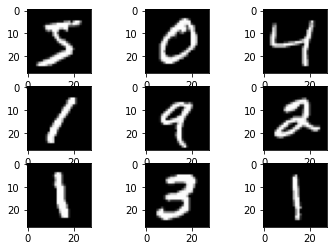

In [ ]:
# example of loading the mnist dataset
from keras.datasets import mnist
from matplotlib import pyplot


# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()


Có một số thông tin đã biết về tập dữ liệu này.

Đầu tiên, tất cả các hình ảnh đều đã được xử lý qua, chẳng hạn như mỗi ảnh chứa 1 và chỉ 1 chữ số, các ảnh đều có kích thước 28x28 pixel và là ảnh đen trắng. Do đó, có thể reshape mảng dữ liệu để có một kênh màu duy nhất.

Thứ hai, bài toán phân loại này có 10 lớp và mỗi lớp đại diện cho một số nguyên duy nhất. Do đó, có thể sử dụng one-hot encoding để thay đổi output thành một vector nhị phân gồm 10 phần tử, với các phần tử đều bằng 0 trừ phần tử nằm ở vị trí tương ứng với lớp đó (bằng 1). Điều này được thực hiện bởi hàm [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical). Việc áp dụng one-hot encoding để phục vụ việc định nghĩa hàm mất mát (loss function) về sau.

In [ ]:
from tensorflow.keras.utils import to_categorical


# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single color channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
  

## Chuẩn bị dữ liệu pixel

Giá trị của pixel trong ảnh là một số tự nhiên nằm trong khoảng từ 0 đến 255, biểu thị màu từ đen đến trắng.

Có thể chuẩn hóa giá trị đó để nằm trong đoạn $ [0; 1] $. Để làm điều đó, trước tiên cần chuyển kiểu dữ liệu từ unsigned integer sang float, sau đó chia cho 255 là giá trị cao nhất.

In [ ]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range [0; 1]
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


# Thiết kế mô hình cơ sở

## Lý do chọn mô hình CNN

Khi nhắc đến những bài toán học máy sử dụng mô hình mạng thần kinh nhân tạo và có input là hình ảnh, CNN thường là một trong những thuật toán đầu tiên được nghĩ đến. Mạng thần kinh kết nối đầy đủ (fully connected neural network) bộc lộ rất rõ những hạn chế của mình trong bài toán này. Chẳng hạn như với một ảnh đen trắng kích thước 28x28, input layer sẽ có 784 node. Trong khi các pixel ở gần nhau thường có mối liên hệ mật thiết hơn hẳn các pixel ở xa thì ở đây mỗi pixel của layer kế tiếp lại liên kết tới toàn bộ các pixel ở layer trước. Điều này làm tăng chi phí giải quyết bài toán lên gấp bội.

CNN cải thiện được các nhược điểm đã kể trên. Trước hết, mỗi pixel chỉ liên kết với một số lượng nhỏ các pixel lân cận, giảm đáng kể chi phí bài toán (ví dụ, 9 pixel thay vì 784 với bài toán này). Trong khi đó, phép tính tích chập cho phép lấy ra các đặc trưng khác nhau của hình ảnh tùy thuộc vào kernel. Vì vậy các đặc trưng của hình ảnh, hay nói cách khác, độ chính xác của mô hình gần như được giữ nguyên. Ngoài ra, mô hình CNN đơn giản và dễ triển khai, phù hợp với bài toán này.

## Định nghĩa mô hình

Em sẽ xác định một mô hình CNN cơ sở để giải quyết bài toán.

Một mô hình gồm có 2 phần chính: phần trích xuất đặc điểm bao gồm các convolutional và pooling layer, và phần phân loại sẽ đưa ra dự đoán.

Về phần trích xuất đặc điểm, có thể bắt đầu với một số lượng nhỏ (32) các kernel kích thước (3, 3) và kèm theo sau là một max pooling layer. Kết quả trả về có thể được làm phẳng để cung cấp các đặc điểm của hình ảnh cho phần phân loại.

Bởi vì bài toán phân loại này có 10 lớp, sẽ cần output layer gồm 10 nút với giá trị là dự đoán xác suất hình ảnh có thuộc lớp đó hay không. Do đó chọn hàm kích hoạt ở output layer là hàm softmax: $ a_k = \frac{e^{z_k}} {\sum_{i=1}^{10} e^{z_i}} $.

Giữa phần trích xuất đặc điểm và output layer, có thể thêm một fully-connected layer để tổng hợp các đặc điểm của hình ảnh, cụ thể trong mô hình này là 100 node.

Ngoại trừ output layer, các layer khác đều sử dụng hàm kích hoạt ReLU $ g(z) = \max\{0, z\} $ và khởi tạo trọng số He.

API [Optimizers](https://keras.io/api/optimizers/) của Keras sẽ được sử dụng để đưa thuật toán Stochastic Gradient Descent vào mô hình. Thuật toán này sẽ được cấu hình cẩn trọng với learning rate 0.01 và momentum 0.9.

Hàm mất mát categorical cross entropy $ H(y, \hat{y}) = - \sum_{i=1}^{10} y_i * log(\hat{y_i}) $ được sử dụng hiệu quả để đánh giá độ chênh lệch giữa dự đoán và thực tế, vì nó đưa ra trừng phạt rất nặng cho các giá trị chênh lệch lớn.

Hàm `define_baseline_model()` dưới đây sẽ đưa ra định nghĩa và trả về mô hình này.

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD


# define cnn model
def define_baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Đánh giá mô hình

Sau khi đã định nghĩa được mô hình cơ sở, tiếp đến sẽ đánh giá nó.

Mô hình sẽ được đánh giá bằng kỹ thuật 5-fold cross validation. Tập dữ liệu sẽ được chia thành 5 nhóm, mỗi nhóm sẽ được sử dụng để đánh giá mô hình được đào tạo bởi 4 nhóm còn lại. Giá trị k = 5 được chọn đủ để có cơ sở cho việc đánh giá lặp lại, đồng thời không quá lớn để tiết kiệm thời gian. Mỗi nhóm bao gồm 12,000 hình ảnh, lớn hơn kích thước của test set một chút.

Mô hình cơ sở này sẽ được train bởi 10 epoch với kích thước batch là 32 hình ảnh. Test set của mỗi fold sẽ được sử dụng vừa để đánh giá mô hình trong khi đào tạo (để sau này vẽ learning curve), vừa để đánh giá khi mô hình đã đào tạo xong (để đánh giá hiệu quả của mô hình). Do đó, lịch sử kết quả mỗi lần chạy và khả năng phân loại chính xác đều sẽ được theo dõi.

Hàm `evaluate_model()` dưới đây nhận tập dữ liệu đào tạo làm tham số và trả về 2 list, điểm đánh giá và lịch sử đào tạo.

In [ ]:
from sklearn.model_selection import KFold


# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, model_name, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        if model_name == "baseline":
            model = define_baseline_model()
        elif model_name == "batch_norm":
            model = define_batch_norm_model()
        elif model_name == "incr_depth":
            model = define_incr_depth_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories


## Kết quả

Sau đây là trình bày kết quả mô hình cơ sở đã được đánh giá.

Có 2 khía cạnh cần được trình bày: chẩn đoán hành vi học tập của mô hình trong quá trình đào tạo và ước tính hiệu suất của mô hình. Chúng có thể được thực hiện bằng cách sử dụng các hàm riêng biệt.

Đầu tiên, chẩn đoán hành vi học tập của mô hình sẽ vẽ biểu đồ đường mô tả hiệu năng của mô hình trên training set và test set trong mỗi fold của 5-fold cross validation. Những biểu đồ này có thể dùng để nhận định rằng mô hình đó đang overfitting, underfitting hay khớp với tập dữ liệu.

Em sẽ vẽ 2 biểu đồ, 1 là biểu đồ mất mát, 1 là biểu đồ độ chính xác. Các đường màu xanh lam biểu diễn hiệu suất của mô hình trên training set, còn màu cam là trên test set.

Hàm `summarize_diagnostics()` dưới đây vẽ các biểu đồ đó dựa trên lịch sử đào tạo đã ghi nhận.

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()


Thứ hai, ước tính hiệu suất của mô hình. Điểm số độ chính xác của việc phân loại trong mỗi fold có thể được tóm gọn bằng trung bình và độ lệch chuẩn. Điều này sẽ đưa ra ước tính hiệu suất của mô hình được đào tạo trên tập dữ liệu này. Dạng biểu đồ được sử dụng ở đây là biểu đồ hộp.

Hàm `summarize_performance()` dưới đây vẽ biểu đồ đó dựa trên một list các điếm số thu được trong quá trình đánh giá mô hình.

In [ ]:
from numpy import mean, std


# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()


Hàm `run_test_harness()` dưới đây sẽ gọi tất cả các hàm được định nghĩa phía trên để chạy thử nghiệm.

In [ ]:
# run the test harness for evaluating a model
def run_test_harness(model_name):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY, model_name)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)


Chạy hàm `run_test_harness()` để nhận được kết quả như sau:

> 98.633
> 98.733
> 98.650
> 98.850
> 98.783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


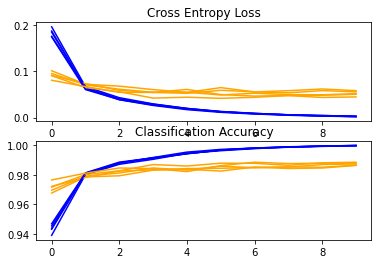

Accuracy: mean=98.730 std=0.081, n=5


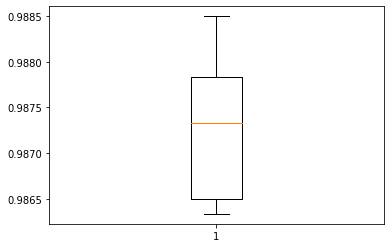

In [ ]:
# entry point, run the test harness
run_test_harness("baseline")


Trong 5 dòng đầu tiên, có thể thấy các kết quả đều đạt được độ chính xác lớn hơn 98%. Đây là một kết quả tốt.

Kế tiếp, trong biểu đồ hành vi học tập, có thể thấy rằng mô hình nhìn chung phù hợp với tập dữ liệu. Biểu hiện là các đường cong ứng với training set và test set đều có vẻ hội tụ và không có dấu hiệu underfitting hay overfitting.

Sau đó, một tóm tắt về hiệu suất của mô hình được đưa ra. Có thể thấy mô hình đạt độ chính xác trung bình 98.730% là hợp lý.

Cuối cùng, từ biểu đồ hộp có thể thấy được phân bố độ chính xác không có điểm gì bất thường.

Vậy mô hình cơ sở nhìn chung đã hoạt động khá tốt.

# Cải tiến mô hình

Có nhiều cách để cải tiến mô hình cơ sở này. Em sẽ thử một số cách cấu hình thường đem lại những thay đổi tích cực.

## Chuẩn hóa hàng loạt


Một cách tiếp cận có thể đẩy nhanh quá trình học một mô hình và dẫn đến cải tiến hiệu suất lớn là chuẩn hóa hàng loạt (batch normalization). Trong phần này, em sẽ đánh giá tác động của quá trình chuẩn hóa hàng loạt đối với mô hình cơ sở.

Chuẩn hóa hàng loạt có thể thực hiện sau convolutional và fully connected layer. Nó có tác dụng thay đổi phân bố đầu ra của layer đó, cụ thể bằng cách chuẩn hóa các đầu ra về dạng chuẩn tắc: $ (\mu, \sigma) = (0, 1) $. Điều này nhằm ổn định và thúc đẩy quá trình học tập.

Định nghĩa mô hình cơ sở có thể được cập nhật để sử dụng chuẩn hóa hàng loạt sau hàm kích hoạt của convolutional và fully connected layer. Hàm `define_batch_norm_model()` dưới đây định nghĩa mô hình đã được cập nhật theo cách đó.

In [ ]:
from tensorflow.keras.layers import BatchNormalization


def define_batch_norm_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Chạy thử đánh giá mô hình mới:

> 98.592
> 98.625
> 98.708
> 98.858
> 98.775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


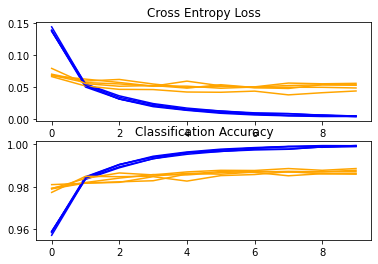

Accuracy: mean=98.712 std=0.097, n=5


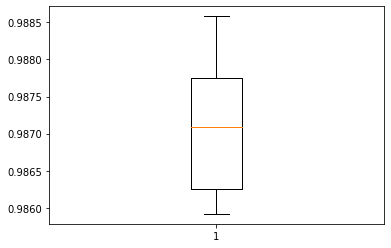

In [ ]:
# entry point, run the test harness
run_test_harness("batch_norm")


Sử dụng những đánh giá tương tự mô hình cơ sở, có thể nhận thấy hiệu suất mô hình nhìn chung giảm nhẹ. Phân phối độ chính xác vẫn không có gì bất thường, khả năng hội tụ của các đường cong của 2 mô hình khá tương đồng.

Từ đó có thể rút ra, chuẩn hóa hàng loạt không đem lại lợi ích gì trong việc cải tiến mô hình cơ sở.

## Tăng độ sâu


Có 2 cách tiếp cận để tăng độ sâu cho mô hình trong bài toán này: tăng độ sâu ở phần trích xuất đặc điểm, hoặc ở phần phân loại. Cảm quan cho rằng việc tăng độ sâu ở phần trích xuất đặc điểm có lẽ sẽ đem lại hiệu quả cao hơn, nên phần này em sẽ cải thiện độ sâu của phần trích xuất đặc điểm và theo dõi ảnh hưởng của nó tới mô hình.

Ta có thể tăng độ sâu của phần trích xuất đặc điểm dựa theo mô hình VGG-16 bằng cách thêm các convolutional và pooling layer với cùng kích thước kernel, trong khi tăng số lượng kernel lên. Trong lần cải thiện này, em sẽ thêm 2 convolutional layer với 64 kernel, kèm theo là 1 max pooling layer.

Hàm `define_incr_depth_model()` dưới đây định nghĩa mô hình đã được cập nhật theo cách đó.

In [ ]:
def define_incr_depth_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Chạy thử đánh giá mô hình mới:

> 98.992
> 99.075
> 99.017
> 99.167
> 99.008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


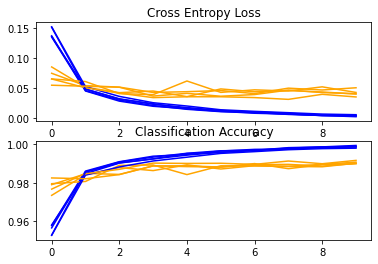

Accuracy: mean=99.052 std=0.064, n=5


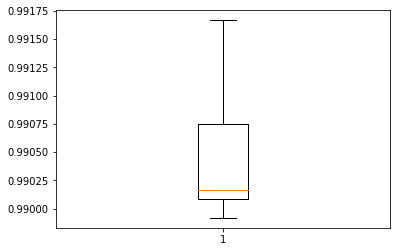

In [ ]:
# entry point, run the test harness
run_test_harness("incr_depth")


Có thể thấy rằng tổng thể độ chính xác đã được cải thiện. Độ chính xác trung bình tăng từ 98.730% lên 99.052%, độ lệch chuẩn giảm từ 0.081% xuống 0.064%. Các đồ thị vẫn cho thấy không có dấu hiệu overfitting hay underfitting. Những điều trên cho phép kết luận tăng độ sâu có ảnh hưởng tích cực đến hiệu suất của mô hình.

# Mô hình cuối cùng

Em sẽ chọn mô hình được cải tiến bằng cách tăng độ sâu làm mô hình cuối cùng.

In [ ]:
def define_final_model():
    return define_incr_depth_model()


## Lưu mô hình cuối cùng

In [ ]:
def save_final_model():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_final_model()
	# fit model
	model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('final_model.h5')


save_final_model()


## Đánh giá mô hình cuối cùng

Mô hình cuối cùng phải phù hợp cho tất cả các dữ liệu có sẵn. Vì vậy, test set với 10,000 hình ảnh đã được giữ lại để đánh giá hiệu suất của mô hình này. Đây là một ý tưởng tốt vì mô hình cuối cùng mới chỉ được đào tạo và kiểm tra trên training test.

Bây giờ, mô hình cuối cùng sẽ được đánh giá thông qua việc xử lý test set.

In [ ]:
from tensorflow.keras.models import load_model


# evaluate the final model in the test dataset
def evaluate_final_model():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # load model
    model = load_model('final_model.h5')
    # evaluate model on test dataset
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))


# entry point, run the test harness
evaluate_final_model()


> 99.080


Kết quả đánh giá dựa trên việc xử lý test set của mô hình đã đạt được con số phù hợp với phân phối đã được thử nghiệm trên training test. Như vậy có thể kết luận rằng phân phối đó là phù hợp để dự đoán độ chính xác của mô hình này khi đưa vào thử nghiệm thực tế.

# Đưa ra dự đoán

Mô hình cuối cùng có thể dùng để đưa ra đánh giá trên hình ảnh mới.

Mô hình yêu cầu hình ảnh phải là ảnh đen trắng, được căn chỉnh để có 1 chữ số nằm ở giữa ảnh, và kích thước ảnh là 28x28.

[sample_image.png](https://www.freecodecamp.org/news/content/images/2021/01/test_image_7.png) là một ảnh được trích xuất trong tập dữ liệu test của MNIST. Giả sử hình ảnh này là hoàn toàn mới, chưa từng được thấy trước đó, đã xử lý đủ để trở thành đầu vào. Hãy xem cách mô hình trên dự đoán chữ số trên ảnh (như kỳ vọng là 7).

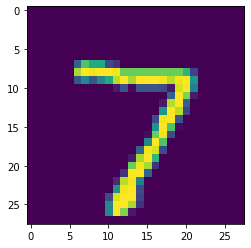

7


In [ ]:
# make a prediction for a new image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from numpy import argmax


# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, color_mode="grayscale", target_size=(28, 28))
    pyplot.imshow(img)
    pyplot.show()
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img


# load an image and predict the class
def run_example():
    # load the image
    img = load_image('sample_image.png')
    # load model
    model = load_model('final_model.h5')
    # predict the class
    digit = argmax(model.predict(img), axis=-1)
    print(digit[0])


# entry point, run the example
run_example()


# Kết luận

Bài toán phân loại chữ số viết tay MNIST đã được giải quyết qua từng bước: chọn mô hình phù hợp, sau đó tìm cách tối ưu hóa mô hình này. Kết quả đem lại độ chính xác hơn 99% là đủ để ứng dụng vào một số công việc trong thực tế. Mô hình này vẫn có thể cải thiện hơn nữa, có thể bằng cách tăng thêm độ sâu dựa theo mô hình VGG-16, hoặc tìm kiếm một hướng đi khác ngoài 2 hướng đã xét trên. Tiềm năng phát triển của mô hình này là lớn, vì ngày nay, VGG-16 với kiến trúc tương đồng vẫn đang được đánh giá là một trong những mô hình tốt nhất cho lớp bài toán phân loại hình ảnh nói chung.

# Tài liệu tham khảo

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

https://nttuan8.com/bai-7-gioi-thieu-keras-va-bai-toan-phan-loai-anh/

https://nttuan8.com/bai-6-convolutional-neural-network/

https://stanford.edu/~shervine/l/vi/teaching/cs-230/

https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init

https://machinelearningcoban.com/2017/01/16/gradientdescent2/

https://machinelearningcoban.com/2017/02/17/softmax/

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/

https://www.geeksforgeeks.org/vgg-16-cnn-model/